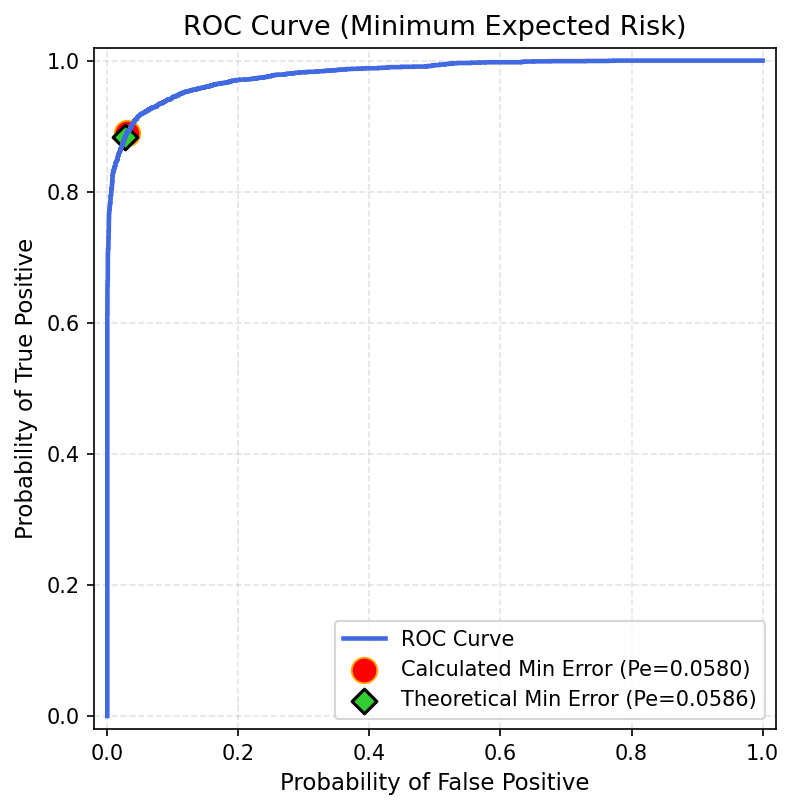


Minimum Expected Risk ROC values:
Calculated tau*: 0.503035,  gamma*: 1.653732
Calculated:    FPR=0.0299,  TPR=0.8899,  Pe=0.05799
Theoretical tau*: 0.619039,  gamma*: 1.857143
Theoretical:  FPR=0.0278,  TPR=0.8842,  Pe=0.05858


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import csv

N = 10000                 
p0, p1 = 0.65, 0.35        
rng = np.random.default_rng(5)

m0 = np.array([-0.5, -0.5, -0.5])
C0 = np.array([[1.0, -0.5,  0.3],
               [-0.5, 1.0, -0.5],
               [ 0.3, -0.5,  1.0]])

m1 = np.array([1.0, 1.0, 1.0])
C1 = np.array([[1.0,  0.3, -0.2],
               [0.3,  1.0,  0.3],
               [-0.2, 0.3,  1.0]])

labels = (rng.random(N) < p1).astype(int)
N1 = labels.sum()
N0 = N - N1

def sample_gaussian(mean, cov, n):
    eigvals, eigvecs = np.linalg.eigh(cov)
    transform = eigvecs @ np.diag(np.sqrt(np.maximum(eigvals, 0)))
    z = rng.standard_normal((n, len(mean)))
    return z @ transform.T + mean

X0 = sample_gaussian(m0, C0, N0)
X1 = sample_gaussian(m1, C1, N1)
X = np.vstack((X0, X1))
labels = np.concatenate((np.zeros(N0, int), np.ones(N1, int)))

def log_gaussian_pdf(X, mean, cov):
    d = X.shape[1]
    sign, logdet = np.linalg.slogdet(cov)
    inv_cov = np.linalg.inv(cov)
    diff = X - mean
    quad = np.einsum("...i,ij,...j->...", diff, inv_cov, diff)
    return -0.5 * (d * np.log(2*np.pi) + logdet + quad)

logp0 = log_gaussian_pdf(X, m0, C0)
logp1 = log_gaussian_pdf(X, m1, C1)
LLR = logp1 - logp0


order = np.argsort(LLR)
LLR_sorted = LLR[order]
labels_sorted = labels[order]

midpoints = (LLR_sorted[:-1] + LLR_sorted[1:]) / 2
taus = np.concatenate(([-np.inf], midpoints, [np.inf]))

P1 = (labels == 1).sum()
P0 = (labels == 0).sum()

tp_cum = np.cumsum(labels_sorted[::-1])[::-1]
fp_cum = np.cumsum((1 - labels_sorted)[::-1])[::-1]

TP = np.empty_like(taus, float)
FP = np.empty_like(taus, float)
TP[0], FP[0] = P1, P0
TP[1:-1], FP[1:-1] = tp_cum[1:], fp_cum[1:]
TP[-1], FP[-1] = 0, 0

TPR = TP / P1
FPR = FP / P0
P_error = FPR * p0 + (1 - TPR) * p1

idx_emp = np.argmin(P_error)
tau_emp = taus[idx_emp]
gamma_emp = np.exp(tau_emp) if np.isfinite(tau_emp) else np.inf
fpr_emp, tpr_emp, perr_emp = FPR[idx_emp], TPR[idx_emp], P_error[idx_emp]

gamma_the = p0 / p1
tau_the = np.log(gamma_the)
idx_the = np.searchsorted(LLR_sorted, tau_the, side="right")
idx_the = np.clip(idx_the, 0, len(TPR) - 1)
fpr_the, tpr_the, perr_the = FPR[idx_the], TPR[idx_the], P_error[idx_the]

with open("roc_q1_partA.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["tau_log_gamma", "FPR", "TPR", "P_miss", "P_error"])
    for t, fpr, tpr, pe in zip(taus, FPR, TPR, P_error):
        writer.writerow([t, fpr, tpr, 1 - tpr, pe])

plt.figure(figsize=(7, 5.5), dpi=150)
plt.plot(FPR, TPR, color="royalblue", linewidth=2.2, label="ROC Curve")
plt.scatter(fpr_emp, tpr_emp, s=150, color="red", edgecolor="orange", linewidths=0.9, label=f"Calculated Min Error (Pe={perr_emp:.4f})")
plt.scatter(fpr_the, tpr_the, s=70, marker="D", color="limegreen",edgecolor="black", linewidths=1.5,label=f"Theoretical Min Error (Pe={perr_the:.4f})")

plt.xlim(-0.02, 1.02)
plt.ylim(-0.02, 1.02)
plt.gca().set_aspect("equal", adjustable="box")
plt.xlabel("Probability of False Positive", fontsize=11)
plt.ylabel("Probability of True Positive", fontsize=11)
plt.title("ROC Curve (Minimum Expected Risk)", fontsize=13)
plt.grid(True, linestyle="--", alpha=0.35)
plt.legend(loc="lower right", frameon=True)
plt.tight_layout()
plt.savefig("roc_q1_partA.png", dpi=160)
plt.show()

print("\nMinimum Expected Risk ROC values:")
print(f"Calculated tau*: {tau_emp:.6f},  gamma*: {gamma_emp:.6f}")
print(f"Calculated:    FPR={fpr_emp:.4f},  TPR={tpr_emp:.4f},  Pe={perr_emp:.5f}")
print(f"Theoretical tau*: {tau_the:.6f},  gamma*: {gamma_the:.6f}")
print(f"Theoretical:  FPR={fpr_the:.4f},  TPR={tpr_the:.4f},  Pe={perr_the:.5f}")
